## NLP Classification and Interpretation
The NLP classification will take the reader through several aspects in model building and propose the best model for predicting price ranges. Then the chosen model will be interpreted according to the SHAP theoretic approach and finally the features for creating space embeddings will be initialized using the predictions from the NLP model. 

## Table of Contents
- [Model building](#0)
- [Price prediction](#1)
- [Saving the data](#2)
- [Model Interpretation](#3)
- [Space Embedding Features](#4)
- [Final Remarks](#5)


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import math
from scipy.sparse import hstack, vstack, coo_matrix, csr_matrix, bmat
sns.set_style("darkgrid")
data_path = "data/"

# Model building <a class="anchor" id="0"></a>

When providing recommendations to travellers, the price point of a shop or restaurant is essential. A student with part time job has a different budget than a person with a full time job. Thus, if you often visit cheap establishments, you will likely love the areas at your destination that serve streetfood and the like, while the guy putting down the company card will have no qualms about having an expensive meal. In this notebook, a NLP classifier for predicting the missing price points of establishments will be trained and interpreted.

In this section a model to predict prices will be built. The model will be based on the following features:
- Bag of Words or TF-IDF features
- Raw review length
- Lix number [see here](https://en.wikipedia.org/wiki/Lix_(readability_test))
- Sentiment score (VADER)

First of all, the reviews will be used to predict the price of the reviewed place. Either a bag of words count or a TF-IDF will be used, with the assumption that TF-IDF will perform better. The BoW count simply tells how any times a word is used in a review where TF-IDF show the relative importance of a given word in the review, taking into account all reviews.  

Secondly, the length of the review is thought to influence the price in some way. A hypothesis could be that reviewers write longer reviews for more expensive establishments. A counter argument could be that longer reviews are mostly reviews with low ratings and has no influence on the price of an establishment. This will be interpreted later in this notebook under model interpretation.

The LIX number is an index that indicates readability of a text. It provides a number from zero and up (though likely below 100), which indicates how hard the text is to understand. A LIX number below 25 are kids books, 35 to 45 is around the level of most newspapers, and above 55 is usually reserved for hard academic papers. The thesis is that more eloquent reviews are written for expensive establishments. 

Finally, the sentiment score is calculated using the VADER (Valence Aware Dictionary and Sentiment Reasoner) framework. This is a popular and powerful framework for performing sentiment analysis and provides three values for a given text. The degree to which the text is positive, negative and neutral. 


First, the preprocessed NLP data is loaded and prepared for analysis.

In [6]:
df = pd.read_csv("data/NLP_data.csv")
df['reviewTextClean'] = df['reviewTextClean'].str.lower()
df.dropna(subset=["reviewTextClean"], inplace=True) # drop rows without a written review

In [7]:
# Create BoW representation of cleaned reviews
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
bow_counts = count_vect.fit_transform(df['reviewTextClean'].values)

In [8]:
print("Length of vocabulary:", len(count_vect.vocabulary_))
print("Length of corpus:", bow_counts.shape[0])

Length of vocabulary: 22973
Length of corpus: 34923


Creating tf-idf representation of cleaned reviews

In [9]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
bow_tfidf = tfidf.fit_transform(bow_counts)

Add remaining features to both bow_counts and bow_tfidf. Here, both LIX and Number of Words are fitted such that they take values between zero and one to match the scale of the TF-IDF. This is done using min-max scaling. 

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[["LIXNorm", "NoWNorm"]] = scaler.fit_transform(df[["LIX", "NumberOfWords"]])

In [11]:
# ensure prices are integers
df["price"] = df["price"].astype(int)

The neutral sentiment score is not added as a feature. It would be heavily correlated with the positive and negative sentiment scores, since the negative, neutral and positive sentiment scores sum to one. 

In [18]:
rem_feats = csr_matrix(df[["posReviewPercent", "negReviewPercent", "LIXNorm", "NoWNorm"]])
bow_counts_full = hstack([bow_counts, rem_feats]).tocsr()
bow_tfidf_full = hstack([bow_tfidf, rem_feats]).tocsr()

In [19]:
print(bow_tfidf_full[0,:])

  (0, 22718)	0.2658723650343767
  (0, 22208)	0.15807811848693062
  (0, 21710)	0.254530635282915
  (0, 21306)	0.24402847754314622
  (0, 21176)	0.16158268183912652
  (0, 20684)	0.28038263916013517
  (0, 20570)	0.12823857290505988
  (0, 19341)	0.09886157163166752
  (0, 19044)	0.20771534105026906
  (0, 17947)	0.16555346954485092
  (0, 13642)	0.09733546247922713
  (0, 13556)	0.1348788956990392
  (0, 11888)	0.1291489010931754
  (0, 11461)	0.14552646615429896
  (0, 9893)	0.3613211781160347
  (0, 8984)	0.06956063293257063
  (0, 8810)	0.06858585623849757
  (0, 7905)	0.15832874300150368
  (0, 6386)	0.10456978984058643
  (0, 5569)	0.245156415110424
  (0, 5220)	0.17050978277327358
  (0, 4915)	0.28437346494788585
  (0, 4145)	0.2805525408883
  (0, 1711)	0.10706632712216521
  (0, 833)	0.27686248133942865
  (0, 22973)	0.141
  (0, 22974)	0.109
  (0, 22975)	0.1362741594039535
  (0, 22976)	0.06657608695652173


The last thing to do before creating models is to split the data into training and test. In this case, to keep a completely clean test set, two splits are made. First we split the data into a development set and a test set. This test set is set aside for final testing once the models has been tuned. The development set is then split into train and validation, such that one can train and validate a model as usual.

In [20]:
from sklearn.model_selection import train_test_split
y = df.price.values-1
text = np.array(df['reviewText'])

# Split into development and test split for tfidf only
X_tfidf_f_dev, X_tfidf_f_test, y_dev, y_test, text_dev, text_test = train_test_split(bow_tfidf_full,  y, text, test_size=0.2, stratify=y)

# Split development into training and validation for tfidf only
X_tfidf_f_train, X_tfidf_f_val, y_train, y_val, text_train, text_val = train_test_split(X_tfidf_f_dev, y_dev, text_dev, test_size=0.1, stratify=y_dev)

In [21]:
# Function that returns performance of classifier 
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
def classification_metrics(header_text, clf, X_train, X_test, y_train, y_test):
    print("="*48)
    print(" "*int((48-len(header_text))/2), header_text)
    print("="*48)
    y_pred = clf.predict(X_train)
    print("Train Accuracy:", accuracy_score(y_train, y_pred))
    y_pred = clf.predict(X_test)
    print("Val Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))
    print(confusion_matrix(y_test, y_pred))

When comparing models, the vanilla versions of the classifiers are fitted to the data and performance is compared. The best performing vanilla classifier is selected for grid search hyperparameter tuning and cross validation. In this comparison, four models are considered where the first is considered as the baseline model to beat.

The first model is a simple dummy classifier which constantly predicts the most frequently occuring class in the training set. In our data, the most frequently occuring price range is the \$\$ price range, accounting for 56% of the training data. This performs about as well as expected with a accuracy of 55.82% for both training and validation. This is also the case when adding the additional features as the most frequent class in the observed *y* does not change with additional features.

In [45]:
# Dummy classifier predicting most frequent class
from sklearn.dummy import DummyClassifier
dummy_X = np.zeros(len(y_train))
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(dummy_X, y_train)
y_pred = dummy.predict(dummy_X)
classification_metrics("Dummy classifier", dummy, dummy_X, X_tfidf_f_val, y_train, y_val)

                 Dummy classifier
Train Accuracy: 0.5604120267260579
Val Accuracy: 0.560486757337151
F1 Score: 0.402624890821091
[[   0  496    0]
 [   0 1566    0]
 [   0  732    0]]


Now that a baseline regressor has been established, it is time to find better performing classifiers. The next model to consider is logistic regression model, which can be seen as a simple but powerful model.

In [46]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_tfidf_f_train, y_train)
classification_metrics("LogisticRegression tf-idf", lr, X_tfidf_f_train, X_tfidf_f_val, y_train, y_val)

            LogisticRegression tf-idf
Train Accuracy: 0.739739102768056
Val Accuracy: 0.6406585540443808
F1 Score: 0.6125203087021588
[[ 150  331   15]
 [  45 1354  167]
 [  11  435  286]]


A significant improvement is seen for the logistic regression compared to the baseline dummy classifier, but there are some indications on overfitting based on the large difference between training and validation accuracy. If this model is chosen, then regularization needs to applied to combat this.

The next model considered is a XGBoost model, which stands for eXtreme Gradient Boosting. Usually this type of ensemble model outperforms logistic regression, so let us see how it performs on our data set.

In [47]:
import xgboost
xgb = xgboost.XGBClassifier(eval_metric="mlogloss", use_label_encoder=False, verbosity=1)
xgb.fit(X_tfidf_f_train, y_train)
classification_metrics("XGBoost tf-idf full", xgb, X_tfidf_f_train, X_tfidf_f_val, y_train, y_val)

               XGBoost tf-idf full
Train Accuracy: 0.7369551384027999
Val Accuracy: 0.6141732283464567
F1 Score: 0.5614361313322017
[[ 113  375    8]
 [  37 1423  106]
 [   7  545  180]]


The performance of XGBoost is largely similar to the logistic regression. The latter performs slightly better and is easier to interpret, hence it is preferred model currently. The final model considered is an ordinal logistic regression from the `mord` library. This could be useful as there is an inherent order to the price points in the sense that `$$` is more expensive than `$` etc. (`$` < `$$` < `$$$`) 

In [51]:
from mord import LogisticAT
lat = LogisticAT()
lat.fit(X_tfidf_f_train, y_train)
classification_metrics("Ordinal Logistic Regression TF-IDF", lat, X_tfidf_f_train, X_tfidf_f_val, y_train, y_val)

        Ordinal Logistic Regression TF-IDF
Train Accuracy: 0.6617483296213809
Val Accuracy: 0.6213314244810307
F1 Score: 0.5715671879732308
[[ 109  381    6]
 [  43 1423  100]
 [   3  525  204]]


The vanilla ordinal logistic regression overfits less than logistic regression and XGBoost, but has worse performance. Therefore, an attempt will be made to fit a logistic regression classifier that is not overfitting through hyperparameter tuning and cross validation. This is done through a grid search using the `GridSearchCV` class from sklearn to tune the hyperparameters.

In [58]:
%%capture
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# As the goal is to classify, the RepeatedStratifiedKFold is used
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

space = dict()
space['solver'] = ['saga']
space['penalty'] = ['l1', 'l2']
space['C'] = [0.1, 1, 10, 100]

search = GridSearchCV(LogisticRegression(), space, cv=cv)
result = search.fit(X_tfidf_f_train, y_train)

In [ ]:
# save model
import pickle
with open("models/NLP_classifier.pkl", "wb") as f:
    pickle.dump(result.best_estimator_, f)

The found hyperparameters can be seen below, and will be used for predicting the price points of the full data set.

In [59]:
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.6261930868610581
Best Hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}


From these parameters the logistic regression object is redefined such that the found parameters are used in the model.  

In [60]:
lr = result.best_estimator_
classification_metrics("LogisticRegression tf-idf full", lr, X_tfidf_f_train, X_tfidf_f_val, y_train, y_val)

          LogisticRegression tf-idf full
Train Accuracy: 0.739619790009545
Val Accuracy: 0.6403006442376521
F1 Score: 0.6120757669887101
[[ 150  331   15]
 [  45 1354  167]
 [  11  436  285]]


In [61]:
y_pred = lr.predict(X_tfidf_f_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average="weighted"))
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.6369362920544023
F1 Score: 0.6097555569160602
[[ 368  829   42]
 [ 152 3350  413]
 [  22 1078  731]]


## Predicting the price for all business <a class="anchor" id="1"></a>
Using the best prediction model on the remaining businesses without a reported price range 

In [24]:
import pickle
lr = pickle.load(open("models/NLP_classifier.pkl", "rb"))

In [25]:
import pandas as pd
df_predict = pd.read_csv("data/NLP_predict.csv")
df_predict['reviewTextClean'] = df_predict['reviewTextClean'].str.lower()
df_predict.dropna(subset=["reviewTextClean"], inplace=True)

The prediction set is transformed to be represented in BoW and tf-idf representation. The transformation is done using the same BoW and tf-idf classes used for the transformation of the input data for the NLP classifiers in the beginning of this notebook.

In [26]:
bow_counts_final = count_vect.transform(df_predict['reviewTextClean'].values)
bow_tfidf_final = tfidf.transform(bow_counts_final)

Add remaining features to both bow_counts and bow_tfidf. Here, both LIX and Number of Words are fitted such that they take values between zero and one to match the scale of the TF-IDF. This is done using min-max scaling. 

In [27]:
df_predict[["LIXNorm", "NoWNorm"]] = scaler.transform(df_predict[["LIX", "NumberOfWords"]])

In [28]:
rem_feats_pred = csr_matrix(df_predict[["posReviewPercent", "negReviewPercent", "LIXNorm", "NoWNorm"]])
bow_counts_final = hstack([bow_counts_final, rem_feats_pred]).tocsr()
bow_tfidf_final = hstack([bow_tfidf_final, rem_feats_pred]).tocsr()

In [29]:
X = bow_tfidf_final
predict = lr.predict(X)
# Get prices back to 1-2-3 format instead of 0-1-2
df_predict["pred_price"] = predict+1

In [30]:
# All prices in the NLP predict dataframe are NaN so the fraction should be 0
sum(sum([df_predict["price"] == df_predict["pred_price"]])) / len(df_predict)

0.0

Since each establishment has multiple reviews, multiple price predictions have been made for each establishments. Thus, in order to predict the price of an establishsment, majority voting is implemented based on the price level predictions for each review.

In [31]:
# First create a series with the Id, predicted price and the counts
p_choice = df_predict.groupby(['gPlusPlaceId', 'pred_price']).size()

# Create dataframe
df_p = p_choice.to_frame('count').reset_index()
# Find largest count for each place Id
df_pmax = df_p.groupby('gPlusPlaceId').max()['count'].reset_index()
# Merge the largest count and the df with the price points
df_pfin = df_pmax.merge(df_p, on=['gPlusPlaceId', 'count'])
# Drop the counts
df_pfin = df_pfin.drop(['count'], axis=1)

# As there are cases where there are equal number of reviews, these cases pick the larger price
df_pfin = df_pfin.groupby('gPlusPlaceId').max()['pred_price'].reset_index()

## Saving the data <a class="anchor" id="2"></a>

Finally, the prices are added to the places data, such that every establishment has a price level associated with it.

In [28]:
df_places = pd.read_csv("data/places_final.csv")
df_places = pd.merge(df_places, df_pfin, how="left", on="gPlusPlaceId")
df_places.head()

,gPlusPlaceId,name,price,lat,lon,city,address,Grid,category,pred_price
0,101742583391038750118,Carpo London,NaN,51.509499,-0.135762,London,"16 Piccadilly, London W1J 0DE, United Kingdom",L159,Retail,2.0
1,100574642292837870712,Premium Cars,NaN,51.514637,-0.064980,London,"10 Commercial Road Premium Cars First Floor, S...",L186,Other,NaN
2,105185983265572241970,eSpares Ltd,NaN,51.479416,-0.179209,London,"Chelsea Wharf, 15 Lots Rd, London, Chelsea SW1...",L40,Wholesale,2.0
3,104500852703501308358,Superdrug,NaN,51.494537,-0.145769,London,"Unit 35, Victoria Railway Station, London SW1V...",L101,Retail,NaN
4,107519298595557659572,Kura,2.0,51.502122,-0.163029,London,"3-4 Park Close, London SW1X 7PQ, United Kingdom",L137,Restaurant,NaN


In [29]:
price = np.zeros(len(df_places))
for i in range(len(df_places)):
    if np.isnan(df_places['price'][i]) and np.isnan(df_places['pred_price'][i]):
        price[i]=np.nan
    elif np.isnan(df_places['price'][i]):
        price[i]=df_places['pred_price'][i]
    elif np.isnan(df_places['pred_price'][i]):
        price[i]=df_places['price'][i]
    else:
        price[i]= df_places['price'][i]

df_places['price']=price

In [30]:
df_places.head()

,gPlusPlaceId,name,price,lat,lon,city,address,Grid,category,pred_price
0,101742583391038750118,Carpo London,2.0,51.509499,-0.135762,London,"16 Piccadilly, London W1J 0DE, United Kingdom",L159,Retail,2.0
1,100574642292837870712,Premium Cars,NaN,51.514637,-0.064980,London,"10 Commercial Road Premium Cars First Floor, S...",L186,Other,NaN
2,105185983265572241970,eSpares Ltd,2.0,51.479416,-0.179209,London,"Chelsea Wharf, 15 Lots Rd, London, Chelsea SW1...",L40,Wholesale,2.0
3,104500852703501308358,Superdrug,NaN,51.494537,-0.145769,London,"Unit 35, Victoria Railway Station, London SW1V...",L101,Retail,NaN
4,107519298595557659572,Kura,2.0,51.502122,-0.163029,London,"3-4 Park Close, London SW1X 7PQ, United Kingdom",L137,Restaurant,NaN


As there are businesses that do not have any reviews in the review data, it will not be possible to predict a price for these.

In [31]:
print('Fraction of the business without a pricerange: ',np.round(len(np.where(np.isnan(df_places['price']))[0])/len(df_places),4))

Fraction of the business without a pricerange:  0.2622


In [32]:
df_places=df_places.drop(['pred_price'], axis=1)

In [33]:
df_places.to_csv(data_path + "places_final_NLP.csv", index=False)

Above, the data with the prices is saved and is ready to be used in further modelling. These prices should help the space embeddings model make great reccomendations to travellers. 

## Model Interpretation <a class="anchor" id="3"></a>

Finally, in order to explore what features has the biggest influence on the price predictions, the overall feature importance of the best prediction model is computed. Since the best prediction model was a logistic regression, we can derive the feature importance as the fitted $\beta$ coefficients. In addition, a SHAP analysis is conducted to inspect the most important features in the dataset, and illustrated using a few selected reviews. 

In [12]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
import shap
from random import sample
import random

%matplotlib inline
FIG_SIZE = (40,18)
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize': FIG_SIZE})
matplotlib.rcParams['figure.figsize'] = FIG_SIZE
plt.rcParams['figure.figsize'] = FIG_SIZE

Defining helper functions to calculate feature importance for the regression model. These were introduced in the course in Week 4 - Interpretability AI of the ABA course.

In [32]:
#Calculating feature imporatnce
def imp_df(column_names, importances):
    """Function for creating a feature importance dataframe"""
    df = pd.DataFrame({'feature': column_names, 'feature_importance': importances})\
           .sort_values('feature_importance', ascending=False)\
           .reset_index(drop=True)
    return df

# plotting feature importance
def var_imp_plot(imp_df, title):
    """Plotting a feature importance dataframe (horizontal barchart)"""
    sns.set(font_scale = 2.5)
    sns.barplot(x='feature_importance', y='feature', data=imp_df, 
                orient='h', color='royalblue')\
       .set_title(title, fontsize = 20)

As the data is on a sparse format, the feature names are extracted from the `CountVectorizer` used to convert the data into BoW representation. Hereafter, the 4 additional features for the review `sentiment`, `LIX number` and `number of words` are appended.

In [33]:
feature_names = count_vect.get_feature_names()
feature_names.extend(["posReviewPercent", "negReviewPercent", "LIXNorm", "NoWNorm"])

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


Creating a dataframe for the `X_train` matrix for tf-idf training data, and adding the feature names for the columns.

In [34]:
X = pd.DataFrame.sparse.from_spmatrix(X_tfidf_f_train, columns=feature_names)

Finding the feature impartance from the linear regression coefficients for all features. 

As the logistic regression model predict 3 values, `$`, `$$` and `$$$`, we have chosen to analyse which features has the biggest influence on the price range of expensive establishments.

In [35]:
lr_imp = imp_df(X.columns, lr.coef_[2]) # predictions in price class 2

To decrease the number of features considered, the 15 features with the highest positive coefficient and the 15 feature with the most negative coefficient are visualised

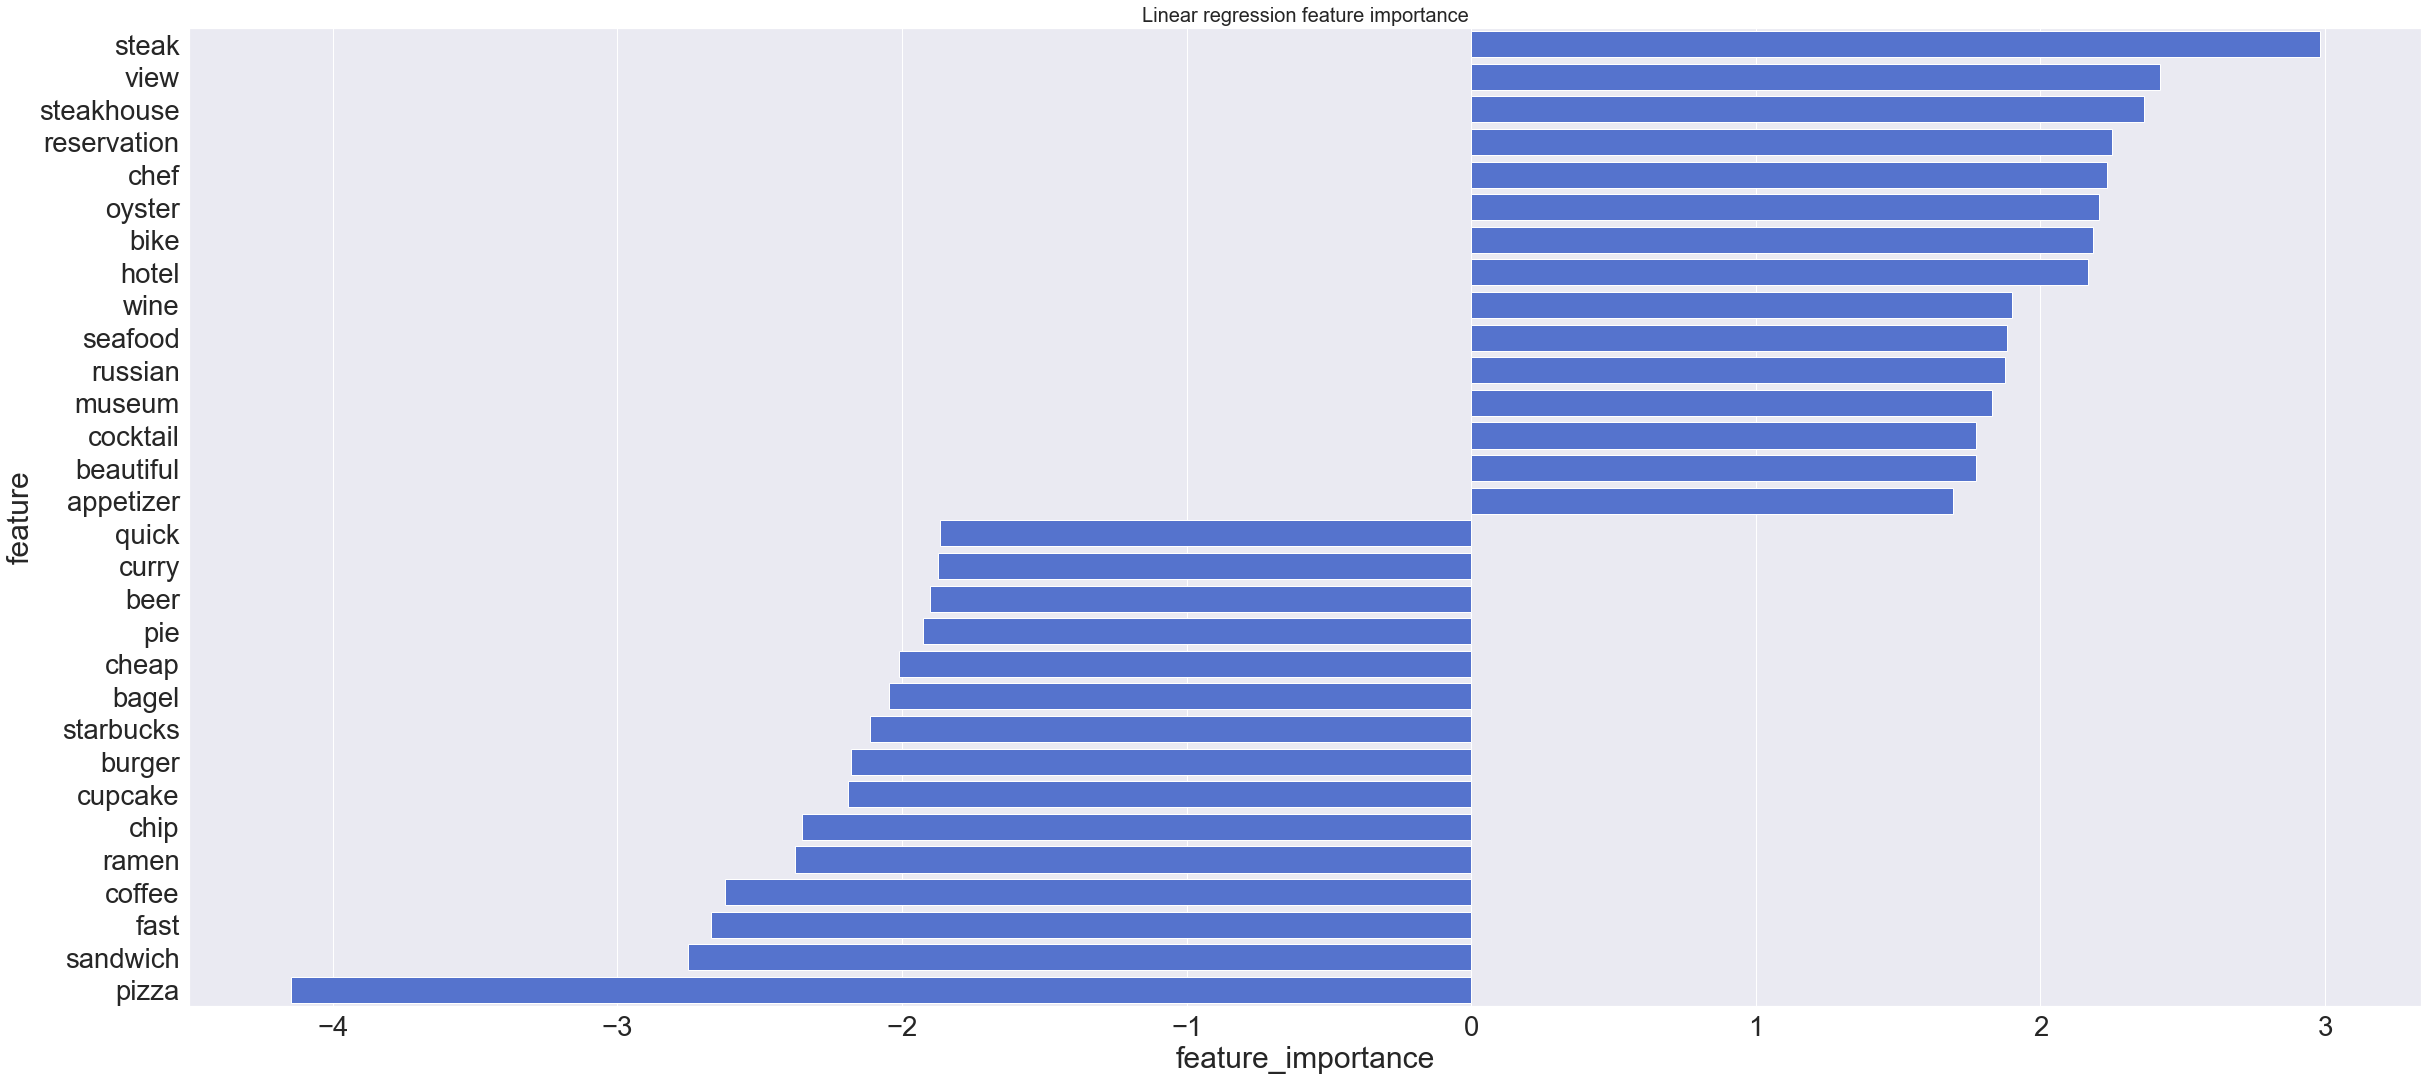

In [ ]:
importance_30 = lr_imp[:15].append(lr_imp[-15:], ignore_index=True)
var_imp_plot(importance_30, 'Linear regression feature importance')

From above plot, it can be derived that words like: *Steak*, *View*, *Reservation* and *Oyster* have a positive effect on the price prediction if they appear in a review. Whereas words like *Pizza*, *Coffee*, *Sandwich* and *Fast* are likely to have a negative effect on the price preduction, meaning that the price will generally be predicted lower if these words appear in a review. 

The above plot also indicates that the LIX number, number of words and sensitivity of a review are not the most important features when predicting the price range of a business.

## SHAP analysis<a class="anchor" id="shap"></a>

To investigate the feature importance for the entire dataset, a SHAP analysis is carried out. From this, we hope to be able to outline the most important features on an aggregated and individual level. 

To minimize the run time of the SHAP analysis, a random sample with size = 2000 is taken from the sparse `X_train` data. 

In [68]:
np.random.seed(0)
all_indices = range(X_tfidf_f_train.shape[0])
random_indices = random.sample(all_indices, 2000)

sorted_random_indices = sorted(random_indices)
X_sample=X_tfidf_f_train[sorted_random_indices, :]

In [69]:
explainer = shap.Explainer(lr, X_tfidf_f_train, feature_names_out=count_vect.get_feature_names_out())

In [70]:
#finding the shap_values for the n=2000 random samples
shap_values = explainer(X_sample)

When visualising the results of the SHAP explainer, negative SHAP values indicates that a feature or a word makes the classifier less likely to predict an establishment as expensive. Whereas a positive shap value indicated high chance of predicting the price class as expensive. This is done on a general level in SHAP using the beeswarm plot for expensive establishments, which should be very similar to the feature importance plot seen previously.

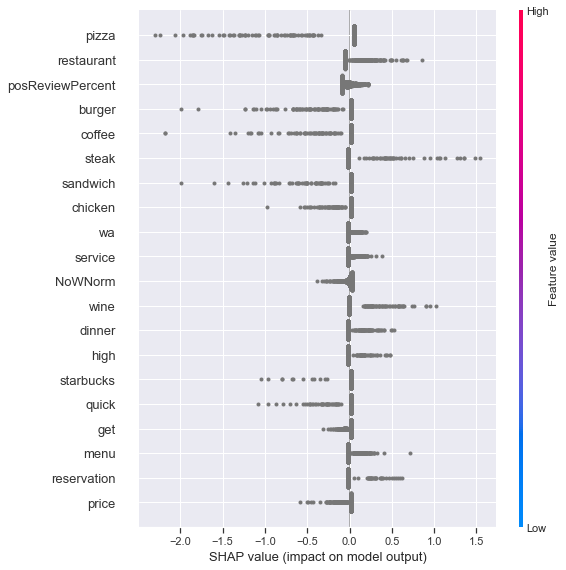

In [ ]:
# SHAP beeswarm plot
shap.summary_plot(shap_values[:,:,2],feature_names=feature_names,max_display=20) 
#max display can be larger if the fig size is adjusted

The beeswarm plot agrees with the feature importance plot on the features that they have in common. Generally it can be concluded that the features are all contributing to one "side" only, ie. the word *Pizza* always indicates that the place is cheap. The effect of *Pizza* on the price range varies but never contributes to a place being expensive. This is good since the effect of the features are strictly the same with regards to a place being cheap or expensive.

The three coming force plots provide an overview of what contributes both positively and negatively to the price prediction. The raw review will also be provided for easier comparison on whether the predictor is doing a good job or not. 

In [72]:
y_pred=lr.predict(X_tfidf_f_train)

In [ ]:
#Checking review number 940
test_review=940
x_index=sorted_random_indices[test_review]
text_train[x_index]

"Bad service. Burnt empanadas, which they try to reserve right back to you. Lame. Overrated. Don't recommend."

In [299]:
print('Actual price range of review: ', y_train[x_index])
print('Predicted price range of review: ',y_pred[x_index])

Actual price range of review:  1
Predicted price range of review:  1


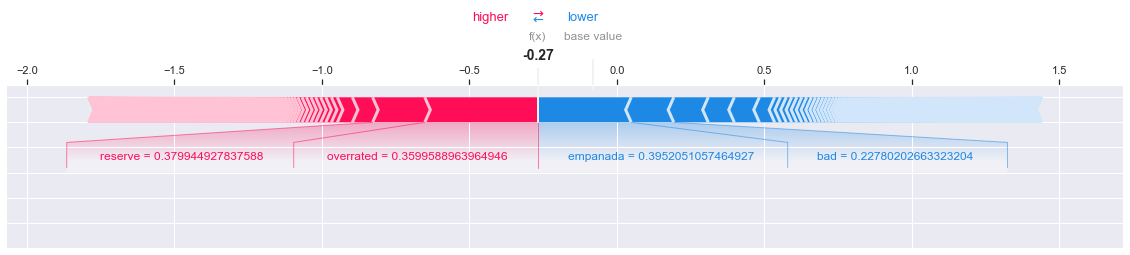

In [300]:
shap.force_plot(explainer.expected_value[2], shap_values[test_review,:,2].values, 
                X.iloc[x_index,:], 
                matplotlib=True)

The above force plot shows a couple of thins that stand out in the bad review of an empanada shop. First, the model seems to misunderstand `reserve` as reserving a table, something it associates with a higher price. Also `overrated` leads to a higher price, which is a word one would often associate with something that is more expensive than it should be and thus it should contribute to a higher price as well. On the other side of the spectrum are words like `empanada` and `bad`, which are shown to decrease the predicted price of the establishment. Empanadas are akin to a small calzone or large dumpling and is sold as a street/finger food and is usually on the cheaper side. The word `bad` is not directly linked to the price, since all places can be bad, but there is some sense to the link.

In [486]:
# checking review number 224
test_review=264
x_index=sorted_random_indices[test_review]
text_train[x_index]

"We ate here on our first night in London after a long journey front Sydney. It was very welcoming with a nice atmosphere with what looked like a company Christmas party/drinks/dinner in full swing. Ordered a delicious foie gras and chicken liver parfait to start with which lived up to it's name. Then the braised beef and angus eye fillet for our mains which were both delicious and cooked to perfection along with a beautiful French red wine which really hit the spot. No room left for dessert :(  Highly recommended"

In [487]:
print('Actual price range of review: ', y_train[x_index])
print('Predicted price range of review: ',y_pred[x_index])

Actual price range of review:  1
Predicted price range of review:  2


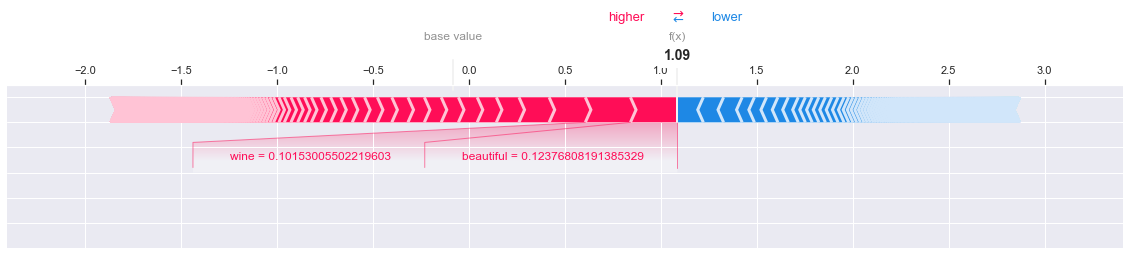

In [488]:
shap.force_plot(explainer.expected_value[2], shap_values[test_review,:,2].values, 
                X.iloc[x_index,:], 
                matplotlib=True)

The other force plot shows a review where the predicted price was wrong. From the plot, `wine` and `beautiful` pulls the price up, while no features worth mentioning pulls the price down. When reading the review the prediction makes sense, as the reviewer mentions several premium items such as foie gras and angus beef.

# Features for Space Embedding Dataframe <a class="anchor" id="4"></a>

Now that the NLP classifier has been created and interpreted, it is time to enrichen the full dataset with the price range predictions for the establishments with no reported price range. To create the dataframe, which can be used for space embedding in London and New York, the features for both cities are aggregated on a grid cell level. 

In [109]:
reviews = pd.read_csv(data_path + "reviews_final.csv")

#### Business per grid cell

The first feature is counting all establishments per grid cell.

In [101]:
df_grid=df_places.groupby('Grid')['gPlusPlaceId'].count().reset_index()
df_grid.rename(columns = {'gPlusPlaceId':'PlaceCount'}, inplace = True)

The next features are the number of establishments in each price range.

In [102]:
df_grid['Price 1'] = 0
df_grid['Price 2'] = 0
df_grid['Price 3'] = 0
df_grid.set_index('Grid', inplace = True)

for grid in df_places.Grid.unique():
    df_grid.loc[grid, 'Price 1'] = df_places.loc[(df_places.Grid==grid) & (df_places.price == 1.0)].gPlusPlaceId.nunique()
    df_grid.loc[grid, 'Price 2'] = df_places.loc[(df_places.Grid==grid) & (df_places.price == 2.0)].gPlusPlaceId.nunique()
    df_grid.loc[grid, 'Price 3'] = df_places.loc[(df_places.Grid==grid) & (df_places.price == 3.0)].gPlusPlaceId.nunique()


Then, a count is made on the number of establishments per category in each grid cell

In [105]:
cat_cols=df_places.groupby(['Grid','category']).count()['gPlusPlaceId'].reset_index()
cat_cols=pd.pivot_table(cat_cols, index='Grid', columns='category', values='gPlusPlaceId').fillna(0)
df_grid=df_grid.join(cat_cols,on='Grid')

In [106]:
df_grid.head(2)

,PlaceCount,Price 1,Price 2,Price 3,Accommodation,Bar,Cafe,Cultural,Education,Health,Other,Outdoors,Restaurant,Retail,Service,Wholesale
Grid,,,,,,,,,,,,,,,,
L0,8,0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,0.0,1.0,0.0
L1,10,0,6,1,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.0,2.0,0.0,2.0,1.0


#### Rating

The number of reviews per grid cell is also included.

In [110]:
mergeddf=df_places.merge(reviews,on='gPlusPlaceId',how='outer').dropna(subset=['name'])
grid_reviews = mergeddf.groupby('Grid').count()['gPlusUserId'].reset_index()
df_grid=df_grid.merge(grid_reviews.rename(columns={'gPlusUserId':'ReviewCount'}),on='Grid')

Overall average rating per cell, and average per establishment category.

When finding the average ratings, all business with less than 3 reviews are removed, as these tend to have a very high average rating. 
A reason for this could be that friends and family give good ratings to newly opened establishments.

In [111]:
mergeddf['rating'] = mergeddf['rating'].astype(float)
# removing all business with less than 3 reviews
avg_reviews = mergeddf.groupby(['Grid','gPlusPlaceId'])['rating'].agg(["count", "mean"]).loc[lambda x: x['count'] > 3, "mean"].reset_index()

# finding the average rating per grid cell
avg_reviews = avg_reviews.groupby('Grid').mean()['mean'].reset_index()

df_grid=df_grid.merge(avg_reviews.rename(columns={'mean':'Rating'}),on='Grid')

In [112]:
#Creating rating name column for each business type's avg rating 
cat_rev = mergeddf.groupby(['Grid','category','gPlusPlaceId'])['rating'].agg(["count", "mean"]).loc[lambda x: x['count'] > 3, "mean"].reset_index()
cat_val=[]

for i in range(len(cat_rev)):
    cat_val.append(cat_rev['category'][i]+'_rating')

cat_rev['cat_val']=cat_val
category_rating=pd.pivot_table(cat_rev, index='Grid', columns='cat_val', values='mean').fillna(0)
df_grid=df_grid.merge(category_rating,on='Grid')

#### Sensitivity

The sentiments are also included as features by counting positive and negative reviews in each grid cell.

In [115]:
positive=np.zeros(len(mergeddf))
negative=np.zeros(len(mergeddf))
#neutral=np.zeros(len(mergeddf))

for i in range(len(mergeddf)):
    sensitiv=[mergeddf['posReviewPercent'][i],mergeddf['negReviewPercent'][i]]#,mergeddf['midReviewPercent'][i]]
    sensitivmax=np.where(sensitiv==np.max(sensitiv))[0]
    
    if math.isnan(sensitiv[0])==False:
        if 0 in sensitivmax:
            positive[i]=1

        if 1 in sensitivmax:
            negative[i]=1   

#        if 2 in sensitivmax:
#            neutral[i]=1
    else:
        0

mergeddf['positive'] = positive
mergeddf['negative'] = negative
#mergeddf['neutral'] = neutral

In [116]:
# Sum of positive and negative ratings per grid cell
sensitivity = mergeddf.groupby('Grid').sum()[['positive','negative']].reset_index()

# Total number of positive and negative ratings in dataframe
count=sensitivity.iloc[:,1:].sum(axis=1)

# distribution of positive and negative reviews per grid cell
sensitivity['PositiveReviews']=sensitivity['positive']/count
sensitivity['NegativeReviews']=sensitivity['negative']/count

df_grid=df_grid.merge(sensitivity[['Grid','PositiveReviews','NegativeReviews']],on='Grid')

The last feature included is the relative review length per grid cell (Avg length per grid cell over avg length for all reviews).

In [117]:
review_len=[]
for i in range(len(mergeddf)):
    if pd.isnull(mergeddf['reviewText'][i])==False:
        review_len.append(len(mergeddf['reviewText'][i].split(" ")))
    else: 
        review_len.append(0)
        

mergeddf['review_len']=review_len   
avg_review_len = np.mean(review_len)

In [118]:
Grid_review_len = mergeddf.groupby('Grid').mean()['review_len'].reset_index()
Grid_review_len['ReviewLength'] = Grid_review_len['review_len']/avg_review_len
df_grid=df_grid.merge(Grid_review_len[['Grid','ReviewLength']],on='Grid')

Final dataframe for grid cell aggregated features

In [125]:
df_grid.head()

,Grid,PlaceCount,Price 1,Price 2,Price 3,Accommodation,Bar,Cafe,Cultural,Education,...,Health_rating,Other_rating,Outdoors_rating,Restaurant_rating,Retail_rating,Service_rating,Wholesale_rating,PositiveReviews,NegativeReviews,ReviewLength
0,L0,8,0,4,0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.020000,0.0,3.942857,0.000000,0.000000,0.000000,0.696000,0.304000,0.536595
1,L1,10,0,6,1,0.0,0.0,1.0,0.0,0.0,...,5.0,0.000000,0.0,4.777778,0.000000,4.000000,0.000000,0.851852,0.148148,0.802238
2,L10,3,0,2,0,0.0,0.0,0.0,0.0,1.0,...,0.0,4.200000,0.0,0.000000,0.000000,0.000000,0.000000,0.857143,0.142857,0.999095
3,L100,74,3,32,17,12.0,6.0,6.0,0.0,1.0,...,3.6,4.024460,0.0,3.711172,4.500000,3.028846,0.000000,0.732975,0.267025,0.895548
4,L101,163,8,78,25,21.0,19.0,20.0,1.0,1.0,...,4.5,4.223132,0.0,3.748855,3.549446,4.311111,3.722222,0.801535,0.198465,0.843739


In [120]:
df_grid.columns

Index(['Grid', 'PlaceCount', 'Price 1', 'Price 2', 'Price 3', 'Accommodation',
       'Bar', 'Cafe', 'Cultural', 'Education', 'Health', 'Other', 'Outdoors',
       'Restaurant', 'Retail', 'Service', 'Wholesale', 'ReviewCount', 'Rating',
       'Accommodation_rating', 'Bar_rating', 'Cafe_rating', 'Cultural_rating',
       'Education_rating', 'Health_rating', 'Other_rating', 'Outdoors_rating',
       'Restaurant_rating', 'Retail_rating', 'Service_rating',
       'Wholesale_rating', 'PositiveReviews', 'NegativeReviews',
       'ReviewLength'],
      dtype='object')

In [122]:
df_grid.to_csv(data_path +'space_embedding_data_NLP.csv')

# Conclusion and final remarks <a class="anchor" id="5"></a>

By choosing the best performing NLP predictor, in this case the logistic regression, price ranges have been predicted for the entire dataset, covering London and NYC. This predictor showed an F1 score of 0.612 which was improved with hyperparameter tuning using cross validation, in this case a grid search model. This obtained a score of 0.64, a slight improvement. This model was used to predict the price points on the full dataset and each establishment was then given a price by aggregating the reviews and choosing the price with the highest count. This is saved such that the data can be used in further analysis.

Then, the model is interpreted using SHAP. As it is a logistic regression NLP model, it is possible to look at the features (words) present for each review and qualitatively assess whether they make sense. This showed that words one would typically associate with more expensive places, such as `steak` or `seafood`, does indeed contribute to a higher predicted price range. On the cheap side, the same patterns show that `pizza` and `fast` pushes the predicted price down. This is illustrated through different plots and examples that highlighted times where the model was correct and where the model was wrong.

Finally, the data for the space embedding model is prepared such that the features are aggregated on grid level and can be used to define neighborhoods. This is shown in the [Space Embeddings notebook](./SpaceEmbeddings.ipynb), which is the next suggested step to learning more about the project.